In [4]:
import warnings
warnings.filterwarnings("ignore")

Importing data

In [5]:
import pandas as pd
hwc = pd.read_csv('hwc.csv')

In [6]:
hwc.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


In [7]:
hwc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


From the info, we can see that there are 5569 rows and 118 columns.

In [8]:
import matplotlib.pyplot as plt

Plotting a graph for 'Habitability'

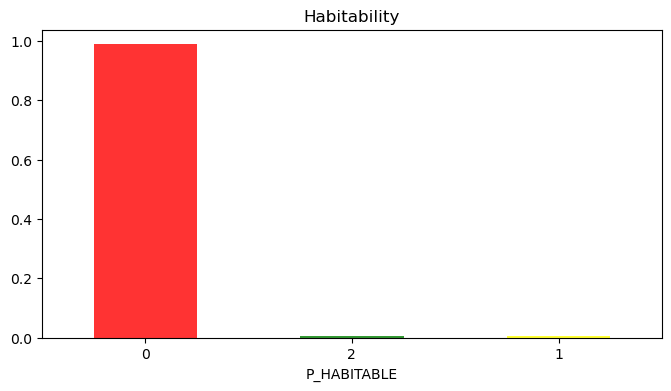

In [9]:
fig = plt.figure(figsize=(8,4))
hwc.P_HABITABLE.value_counts(normalize=True, ascending=False).plot(kind='bar', color=['red','green','yellow'], alpha=0.8, rot=0)
plt.title("Habitability")
plt.show()

In [10]:
hwc['P_HABITABLE'].value_counts(normalize=True)

P_HABITABLE
0    0.987610
2    0.007183
1    0.005207
Name: proportion, dtype: float64

Baseline analysis with the dabl library

In [11]:
import dabl

Target looks like classification
Showing only top 10 of 82 continuous features
Linear Discriminant Analysis training set score: 0.845


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='P_HABITABLE'>,
 [<Figure size 2000x600 with 10 Axes>,
  array([[<Axes: title={'center': '0.844'}, xlabel='P_ESI', ylabel='P_TEMP_SURF'>,
          <Axes: title={'center': '0.806'}, xlabel='P_ESI', ylabel='P_TEMP_EQUIL'>,
          <Axes: title={'center': '0.758'}, xlabel='P_TEMP_SURF', ylabel='S_MASS'>,
          <Axes: title={'center': '0.739'}, xlabel='P_ESI', ylabel='P_TEMP_EQUIL_MAX'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 400x400 with 1 Axes>],
 array([[<Axes: title={'center': 'P_TYPE_TEMP'}>,
         <Axes: title={'center': 'P_TYPE'}>,
         <Axes: title={'center': 'S_TYPE_TEMP'}>,
         <Axes: title={'center': 'P_MASS_ORIGIN'}>,
         <Axes: title={'center': 'P_DETECTION'}>]], dtype=object)]

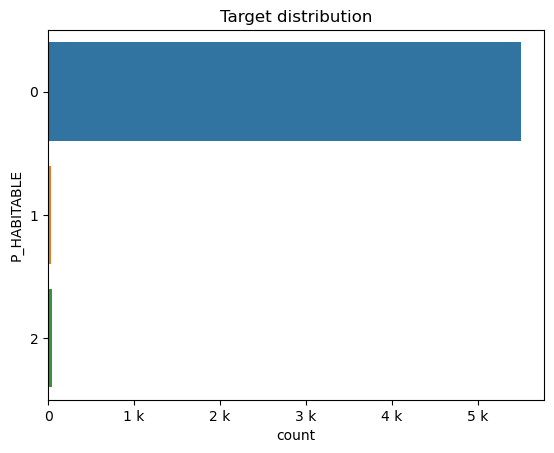

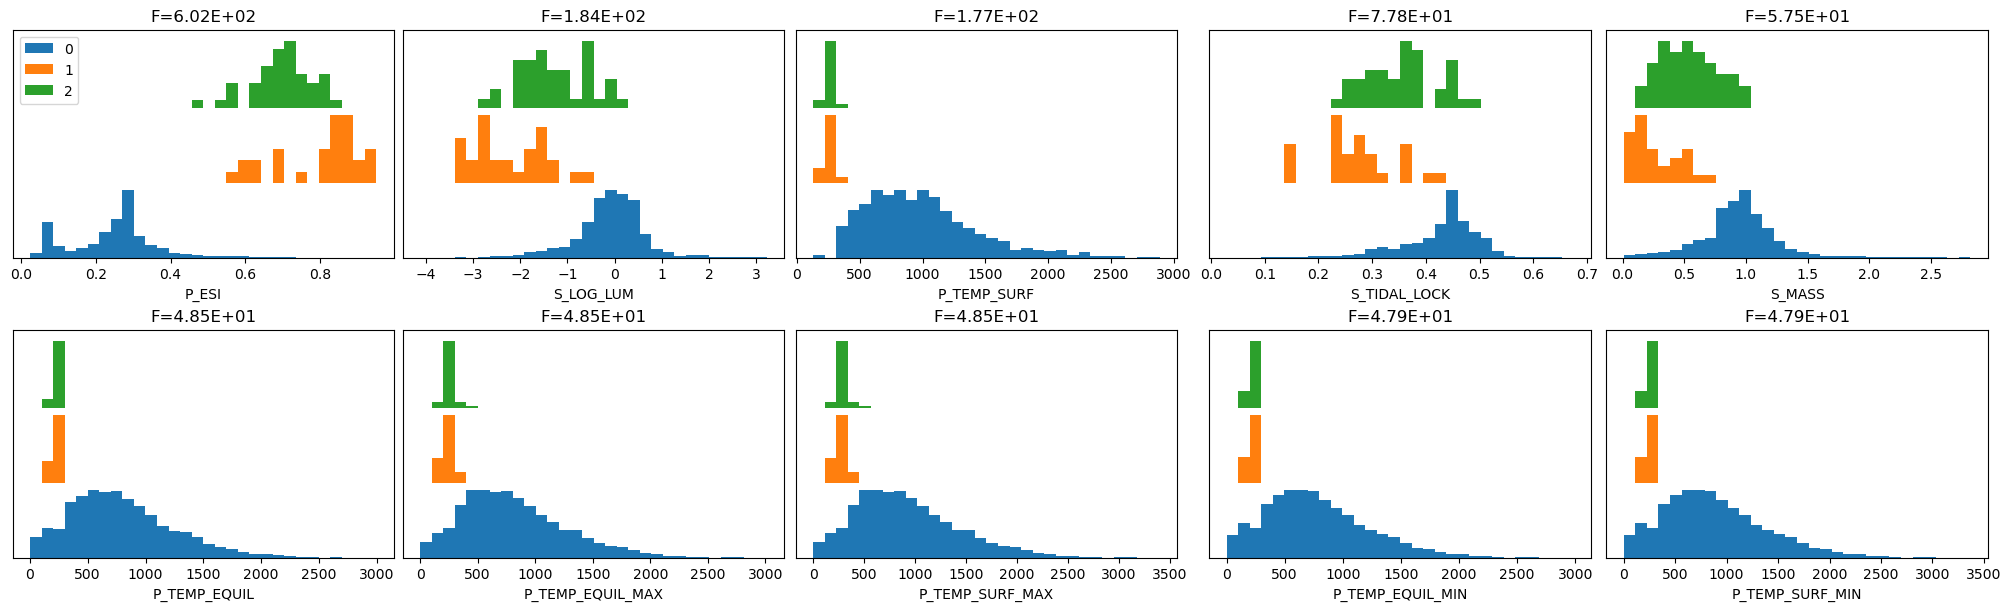

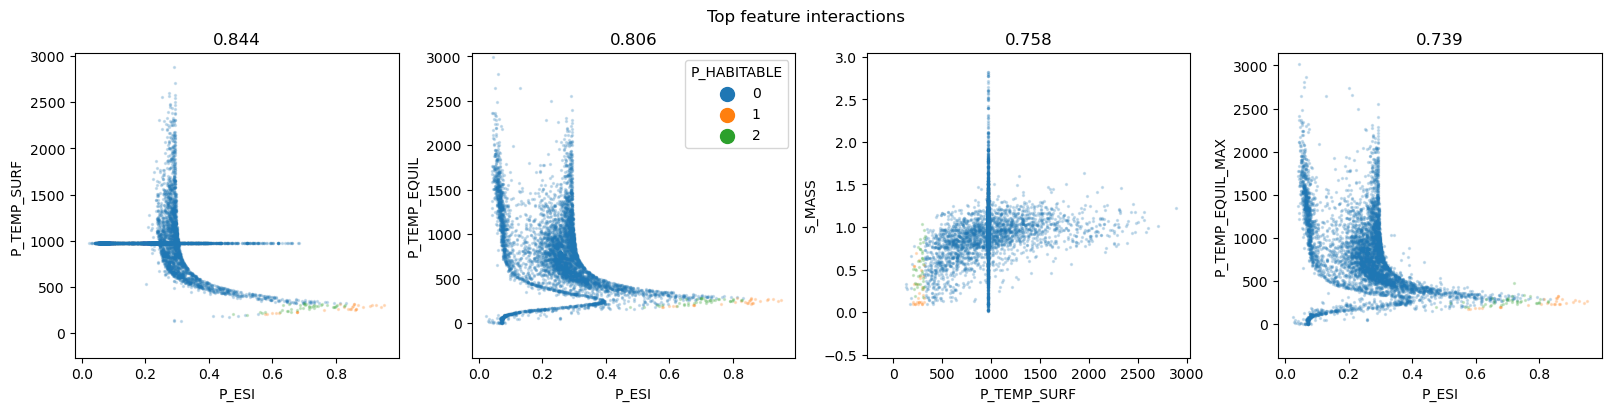

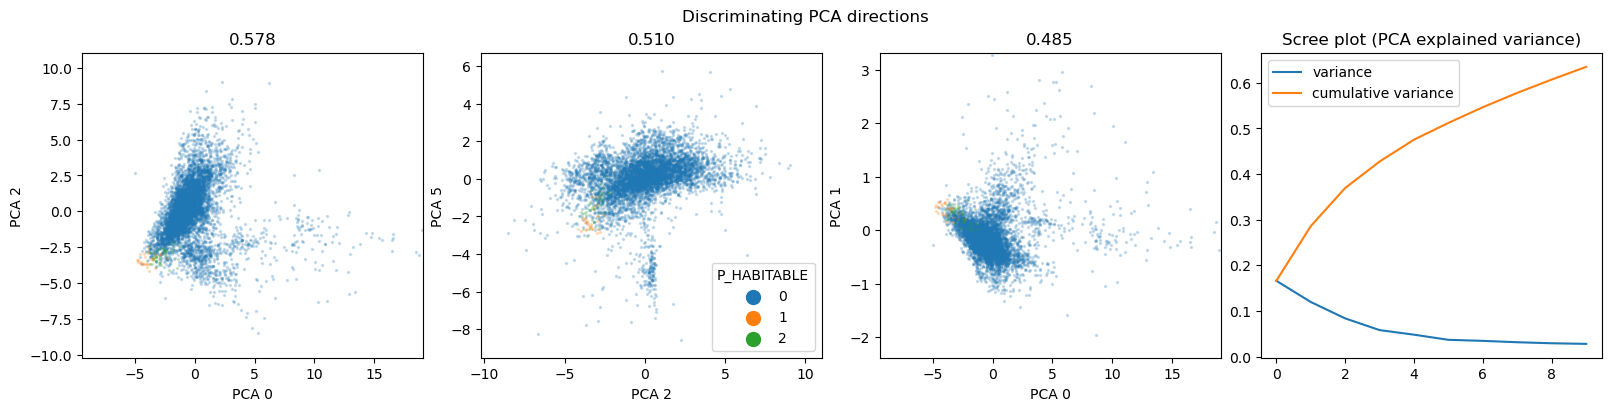

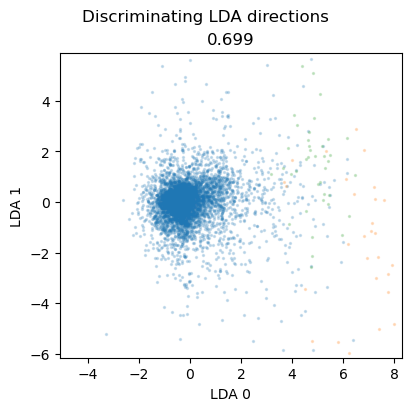

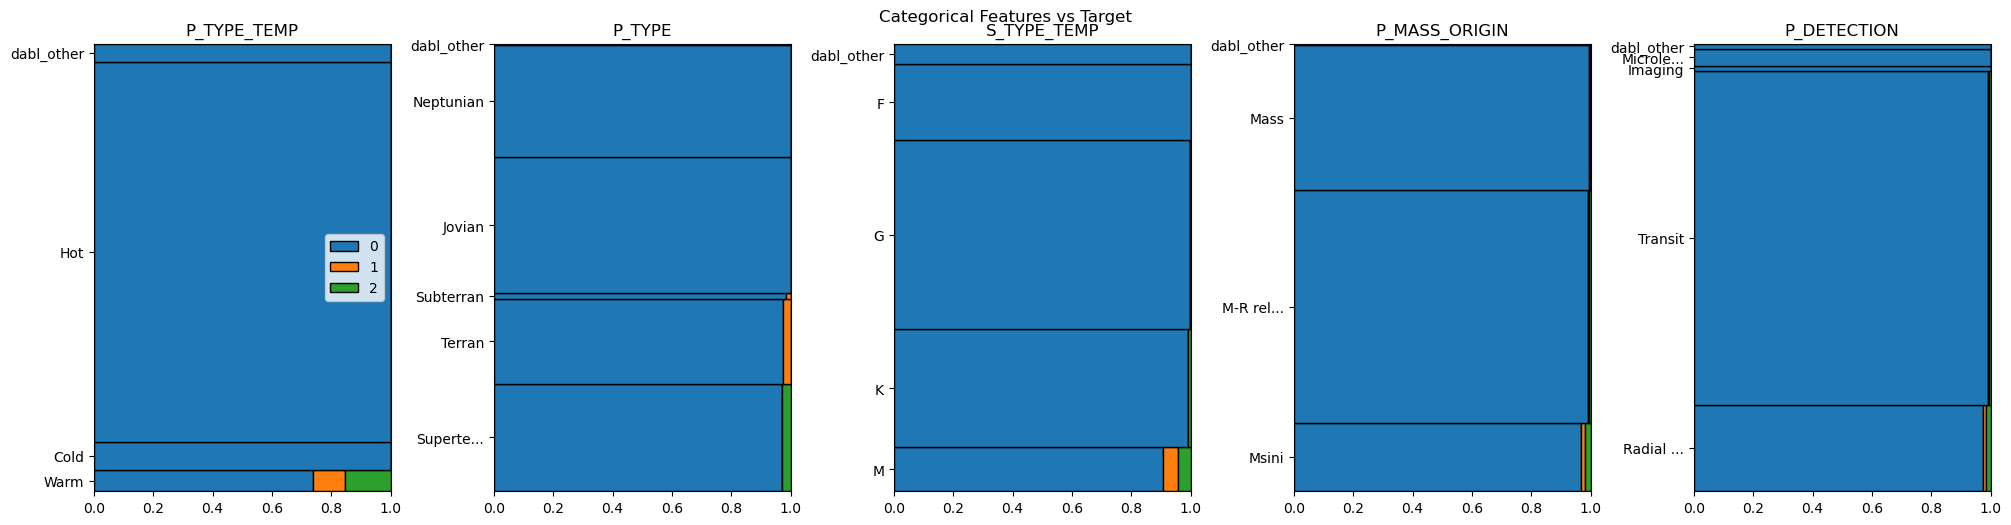

In [12]:
dabl.plot(hwc, target_col='P_HABITABLE')

From the above plots, we can see that the data is highly skewed. 98.7% of the planets are inhabitable, 0.7% of the planets must be habitable and 0.5% of the planets might be habitable.

We are resolving this class imbalance with a resampling strategy.

In [13]:
from sklearn.utils import resample

In [16]:
not_habit = hwc[hwc.P_HABITABLE == 0]
maybe_habit = hwc[hwc.P_HABITABLE == 1]
mostly_habit = hwc[hwc.P_HABITABLE == 2]
maybe_habit_oversampled = resample(maybe_habit, replace=True, n_samples= len(not_habit), random_state=12345)
oversampled  = pd.concat([not_habit, maybe_habit_oversampled])
mostly_habit_oversampled = resample(mostly_habit, replace=True, n_samples=len(not_habit), random_state=12345)
oversampled = pd.concat([oversampled, mostly_habit_oversampled])

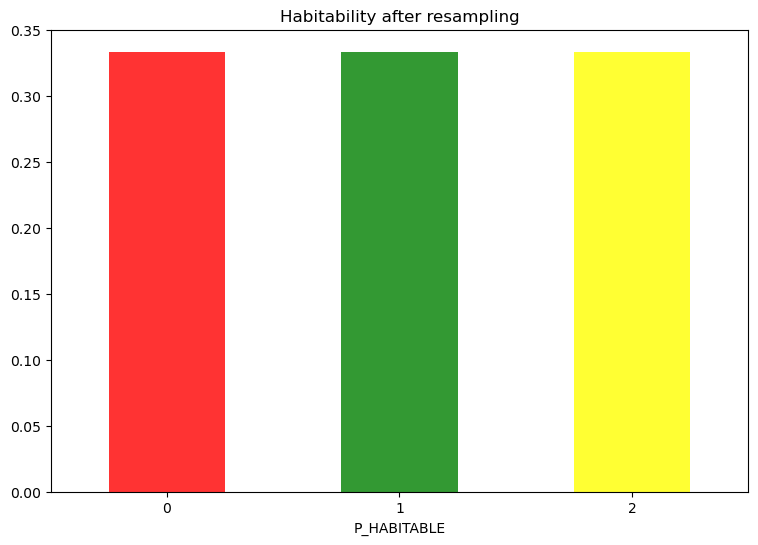

In [17]:
fig = plt.figure(figsize=(9,6))
oversampled.P_HABITABLE.value_counts(normalize=True, ascending=False).plot(kind='bar', color = ['red','green','yellow'], alpha = 0.8, rot=0)
plt.title("Habitability after resampling")
plt.show()

In [18]:
oversampled.P_HABITABLE.value_counts(normalize=True)

P_HABITABLE
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64

Now that each class is having equal proportion, we proceed with data analysis by visualization. 

First, let us explore which detection method is being used extensively over the recent years for exoplanet discovery.

In [19]:
planetary_detec = (oversampled.groupby('P_DETECTION').filter(lambda x: len(x) > 5).groupby(['P_DETECTION', 'P_YEAR']).size().unstack())

In [20]:
import seaborn as sns

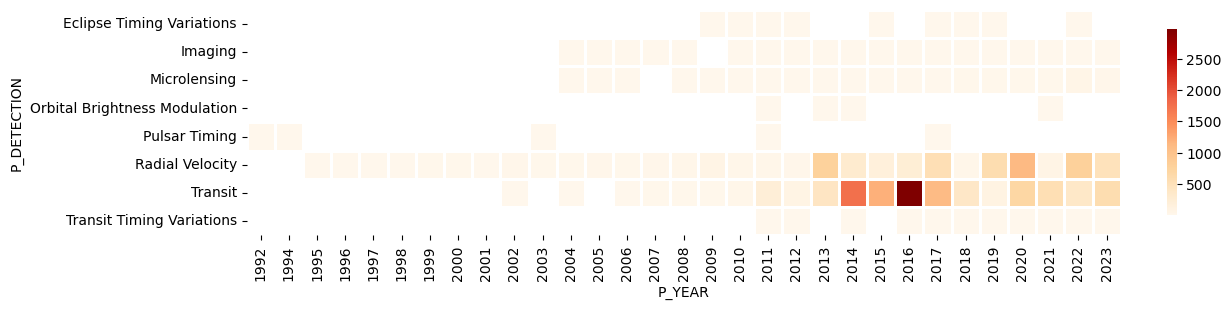

In [22]:
plt.figure(figsize=(12,12))
g = sns.heatmap(planetary_detec, square=True, cbar_kws={'fraction':0.01}, cmap='OrRd', linewidth=1)

from the above heatmap, we can see that 'transit' and 'radial velocity' are two discovery methods that are most prominent. We will be checking how many habitable planets have been discovered using these two methods.

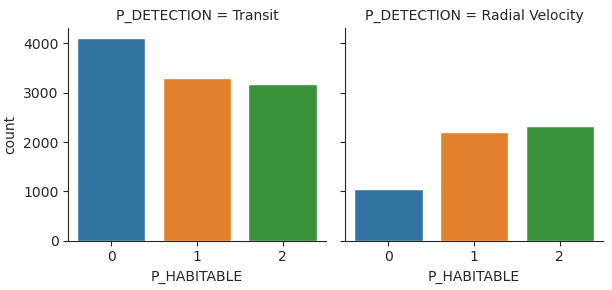

In [30]:
with sns.axes_style(style='ticks'):
    tran_radvel = sns.catplot(
        x="P_HABITABLE", 
        col="P_DETECTION", 
        col_wrap=3, 
        data=oversampled[oversampled['P_DETECTION'].isin(['Radial Velocity','Transit'])], 
        kind='count', 
        height=3.0, 
        aspect=1.0
    )